# 30x4-fold Cross Validation with Ligand Efficiency Scores


### Comparing the performance of ML classifiers and Consensus strategies using ligand efficiency scores

- Ligand Efficiency scores are computed by dividing the number of atoms between the docking score of each molecule.

- This notebook performs the $30 \times 4 cv$ analysis using the `DEFAULT HYPERPARAMETERS` of each ML algorithm, see the results of this notebook.

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../..')
from helper_modules.run_or_load import run_or_load_joblib
from helper_modules.plotting_metrics import PlotMetric
from helper_modules.friedman_and_nemenyi_test import *
%run ../../helper_modules/Helper_functions_for_nRepeats_x_kCV.ipynb

In [2]:
import warnings
warnings.filterwarnings('ignore')
# To avoid warnings related to `STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.` 

### Load docking results

In [3]:
# Define the same `random_state` for all the splits
RANDOM_STATE = 1
ANALYSIS_TYPE = "LIG_EFF-DHYPRM"

In [4]:
protein_name = 'hsp90'

In [5]:
file_name = '../4_Ensemble_docking_results/' + \
            'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
df_dk_res = pd.read_pickle(file_name)

# Extract the features columns: Docking scores
X_raw = df_dk_res.drop('activity', axis = 1)
# Extract the response variable: Activity
y = df_dk_res['activity']

X_raw.shape
X_raw.index.get_level_values(level = 0).unique()

Index(['COCRYS', 'DEKOIS2', 'DUD'], dtype='object', name='library')

- Compute the proportion of active molecules ($R_a$) of the whole dataset.

In [6]:
R_a = round(y.sum() / len(y), 4)
print(f'Ratio of actives {y.sum()}/{len(y)}:')
R_a

Ratio of actives 256/2302:


0.1112

## Ligand Efficiency Scores
### Load the data frame with the `rdkit` molecules

In [7]:
df_out_file = '../2_Molecular_libraries/df_MOLECULES_no_duplicates.obj'
df_all_mols = pd.read_pickle(df_out_file)
df_all_mols = df_all_mols.rename(columns = {'Lig': 'name'})
df_all_mols = df_all_mols.set_index(keys = ['library','name'])
print(df_all_mols.shape)
df_all_mols

(2302, 8)


Activity                                           mol_rdk  \
library name                                                                    
COCRYS  ADP               1  <rdkit.Chem.rdchem.Mol object at 0x7fd0e8efc130>   
        KOS               1  <rdkit.Chem.rdchem.Mol object at 0x7fd0e8efc170>   
        PU3               1  <rdkit.Chem.rdchem.Mol object at 0x7fd0e8efc1b0>   
        PU4               1  <rdkit.Chem.rdchem.Mol object at 0x7fd0e8efc1f0>   
        PU5               1  <rdkit.Chem.rdchem.Mol object at 0x7fd0e8efc230>   
...                     ...                                               ...   
DUD     decoy_974         0  <rdkit.Chem.rdchem.Mol object at 0x7fd0e9041d70>   
        decoy_975         0  <rdkit.Chem.rdchem.Mol object at 0x7fd0e9041df0>   
        decoy_977         0  <rdkit.Chem.rdchem.Mol object at 0x7fd0e9041e70>   
        decoy_978         0  <rdkit.Chem.rdchem.Mol object at 0x7fd0e9041ef0>   
        decoy_979         0  <rdkit.Chem.rdchem.Mol object at 0x7fd0e9041f70>   

                  sanitized       MW  num_atoms  num_rot  num_rings  charge  
library name                                                                 
COCRYS  ADP            True  424.179         27        6          3      -3  
        KOS            True  617.764         44        7          2       1  
        PU3            True  371.441         27        8          3       0  
        PU4            True  311.389         23        6          3       0  
        PU5            True  311.389         23        6          3       0  
...                     ...      ...        ...      ...        ...     ...  
DUD     decoy_974     False  384.461         27        4          3       0  
        decoy_975     False  330.413         23        5          2       0  
        decoy_977     False  332.385         23        6          3       0  
        decoy_978     False  348.428         24        6          2       0  
        decoy_979     False  354.435         25        5          3       0  

[2302 rows x 8 columns]

#### Compute the *Ligand Efficiency* scores

In [8]:
assert np.all(X_raw.index == df_all_mols.index)
X_LE = X_raw.divide(df_all_mols['num_atoms'], axis = 0)
X_LE.shape

(2302, 64)

### Visualize the Docking performance per library

In [9]:
metric_name = 'roc_auc'
metric_kwargs = {'metric_name': metric_name}
libraries = ['DUD', 'DEKOIS2', 'DUD_DEKOIS2', 
             'DUD_DEKOIS2_COCRYS']

raw_performances = []
for lib in libraries:
    df_perfs = PlotMetric(y_true = y.loc[lib.split('_')], 
               df_predictions = X_raw.loc[lib.split('_')], 
               decreasing = True,
              ).format_metric_results(**metric_kwargs)
    raw_performances.append(df_perfs)
raw_performances_per_conf = pd.concat(
                                raw_performances, 
                                keys = [lib.replace('_', '\n')
                                        for lib in libraries], 
                                axis = 1)\
                        .droplevel(1, axis = 1)

ligEff_performances = []
for lib in libraries:
    df_perfs = PlotMetric(y_true = y.loc[lib.split('_')], 
               df_predictions = X_LE.loc[lib.split('_')], 
               decreasing = True,
              ).format_metric_results(**metric_kwargs)
    ligEff_performances.append(df_perfs)
ligEff_performances_per_conf = pd.concat(
                                ligEff_performances, 
                                keys = [lib.replace('_', '\n')
                                        for lib in libraries], 
                                axis = 1)\
                        .droplevel(1, axis = 1)

Top ROC_AUC values
DUD                     0.835
DEKOIS2                 0.691
DUD\nDEKOIS2            0.738
DUD\nDEKOIS2\nCOCRYS    0.618
dtype: float64


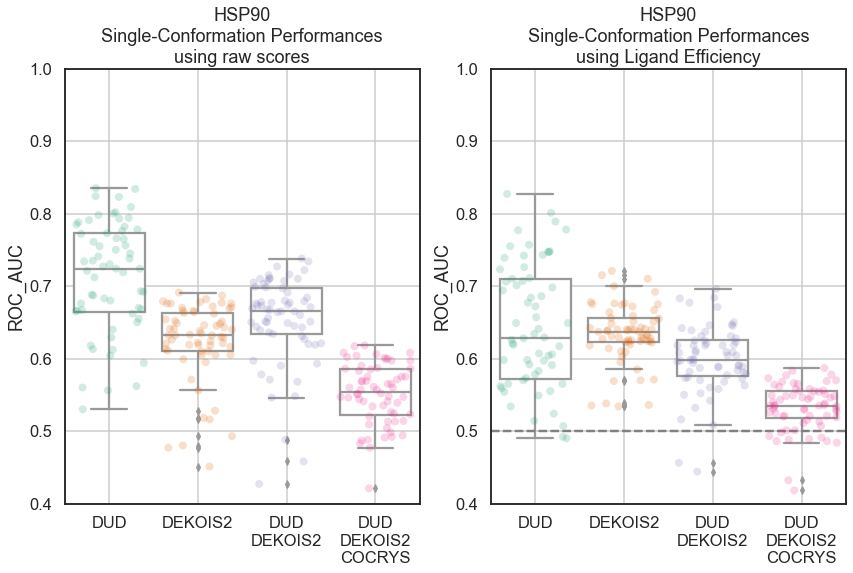

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (14,8))

# Docking performances with raw docking scores

sns.stripplot(data = raw_performances_per_conf, 
              jitter = 0.4, alpha = 0.2, 
              size = 8, ax = ax[0])
sns.boxplot(data = raw_performances_per_conf, 
            color = '#FFFFFFFF', 
            ax = ax[0])
ax[0].set(ylim = (0.4,1), 
       title = f'{protein_name.upper()}' + 
       '\nSingle-Conformation Performances\nusing raw scores',
       ylabel = f'{metric_name.upper()}')
plt.axhline(0.5, label = 'Random', color = 'gray', ls = '--')
ax[0].grid()

# Docking performances with raw docking scores
ax[1] = sns.stripplot(data = ligEff_performances_per_conf, 
                      jitter = 0.4, alpha = 0.2, 
                      size = 8, ax = ax[1])
sns.boxplot(data = ligEff_performances_per_conf, 
            color = '#FFFFFFFF', 
            ax = ax[1])
ax[1].set(ylim = (0.4,1), 
       title = f'{protein_name.upper()}' + 
       '\nSingle-Conformation Performances\nusing Ligand Efficiency',
       ylabel = f'{metric_name.upper()}')
plt.axhline(0.5, label = 'Random', color = 'gray', ls = '--')
ax[1].grid()
print(f'Top {metric_name.upper()} values')
print(raw_performances_per_conf.max(axis = 0))

### Keep only the values to perform the 30x4cv analysis

In [11]:
X = X_LE.values
y = y.values

### Machine Learning Classifiers

- Define the ML algorithms with the preselected hyperparameters.

#### Dummy Classifier

In [12]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

#### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression 

lr = LogisticRegression()

#### Gradient Boosting Trees

In [14]:
from xgboost import XGBClassifier

hyparams = {'n_estimators'      : 500,        
            'eval_metric'       : 'logloss',
            'use_label_encoder' : False
           }
xgb = XGBClassifier(**hyparams)

#### Dictionary of ML classifiers

In [15]:
# ML Classifiers
ml_classifiers = {
    'ml_lr'  : lr,
    'ml_xgb' : xgb,
    'ml_dclf': dclf
}

### Consensus Strategies

In [16]:
from helper_modules.consensus_strategies import \
    get_mean_score, get_min_score, get_geom_mean_score

In [17]:
cs_functions = {
    'cs_MEAN': get_mean_score,
    'cs_GEOM': get_geom_mean_score,
    'cs_MIN' : get_min_score
}

### SBVS methods (estimators) dictionary

In [18]:
estimators = {**ml_classifiers, **cs_functions}

In [19]:
# Map new names for each VS method, for plotting
full_names = ['LR', 'GBT', 'DClf', 
              'csAVG', 'csGEO', 'csMIN']
sbvs_names = dict(zip(
    estimators.keys(),
    full_names))
sbvs_names

{'ml_lr': 'LR',
 'ml_xgb': 'GBT',
 'ml_dclf': 'DClf',
 'cs_MEAN': 'csAVG',
 'cs_GEOM': 'csGEO',
 'cs_MIN': 'csMIN'}

### Evaluation metrics

In [20]:
metrics = dict(
    # AUC-ROC
    roc_auc   = {'metric_name': 'roc_auc'},
    # Normalized Enrichment Factor
    nef_Ra = {'metric_name': 'ef', 
              'fraction'   : R_a, 
              'method'     : 'normalized'}
    )

## 30x4 Cross validation

In [21]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def nk_rep_cross_validation_SAVE(filename, **kwargs):
    return nk_rep_cross_validation(**kwargs)

In [22]:
# ********************
# Perform the 30x4 CV
# ********************

n_repeats = 30
n_splits  = 4
evaluation_name = f'{n_repeats}x{n_splits}cv' + f'_{ANALYSIS_TYPE}'
cv30x4, y_preds, splits = nk_rep_cross_validation_SAVE(
    filename = f'./cachedir/{evaluation_name}_{protein_name}',
    estimators = estimators, 
    X = X,
    y = y, 
    metrics   = metrics, 
    n_repeats = n_repeats, 
    n_splits  = n_splits,
    y_preds_return = True,
    random_state   = RANDOM_STATE
)

# Rename columns 
cv30x4 = cv30x4.rename(columns = sbvs_names)

File loaded: ./cachedir/30x4cv_LIG_EFF-DHYPRM_hsp90


### Compute the Single-Conformation Performances (SCP)

In [23]:
%%time
# **********************************
# Extract the individual predictions
# **********************************
# Single conformation performance SCP reference values

# Use the same `random_state` value 
# to parse to `RepeatedStratifiedKFold`
filename = './cachedir/SCP_values_randState_' +\
            f'{RANDOM_STATE}_{protein_name}_{ANALYSIS_TYPE}'
scp_values = n_reps_k_folds_SCP_SAVE(
                filename  = filename,
                metrics   = metrics,
                X = X, y  = y, 
                n_splits  = n_splits, 
                n_repeats = n_repeats,
                random_state = RANDOM_STATE
              )

# Report the values
for m, values in scp_values.items():
    print(f'SCP values of {m} => ' + 
          f'mean: {values[0]:.2f} +/- {values[1]:.2f}, ' + 
          f'max: {values[2]:.2f}')

File loaded: ./cachedir/SCP_values_randState_1_hsp90_LIG_EFF-DHYPRM
SCP values of roc_auc => mean: 0.53 +/- 0.05, max: 0.68
SCP values of nef_Ra => mean: 0.18 +/- 0.05, max: 0.39
CPU times: user 1.66 ms, sys: 2.06 ms, total: 3.71 ms
Wall time: 2.03 ms


<p style='color: black; background-color: #F9E5AB; padding: 5px;'>
    We will use <b>R</b> for plotting
</p>

In [24]:
%load_ext rpy2.ipython

### AUC-ROC Results

In [25]:
# **********************
# Descriptive Statistics
# **********************

# ROC-AUC
metric_name='roc_auc'
df_R = order_df(cv30x4, 
                metric_name).loc[metric_name]
scp_values_R = list(scp_values[metric_name])
# Descriptive statistics
report_descriptive_stats(cv30x4, metric_name)

Meadians:


,DClf,csGEO,csAVG,csMIN,LR,GBT
medians,0.501415,0.526455,0.530385,0.560595,0.74147,0.848535


IQRs:


,DClf,csGEO,csAVG,csMIN,LR,GBT
IQRs,0.030385,0.06022,0.057455,0.04582,0.04704,0.025005


Normality test results (Sahpiro-Wilk):


,LR,GBT,DClf,csAVG,csGEO,csMIN
Normality,1,1,1,1,1,1


Friedman Test:


,chi^2,dof,p_value
Friedman Test,529.961905,5,2.715667e-112


In [26]:
%%R
full_names <- c('LR', 'GBT', 'DClf', 
                'csAVG', 'csGEO', 'csMIN')
cbbPalette <- c('#785EF0', '#3F93D2', '#44AA99', 
                '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

R[write to console]: Registering fonts with R

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘matrixStats’


R[write to console]: The following object is masked from ‘package:dplyr’:

    count


R[write to console]: The following object is masked from ‘package:plyr’:

    count


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

R[write to console]: ── Co

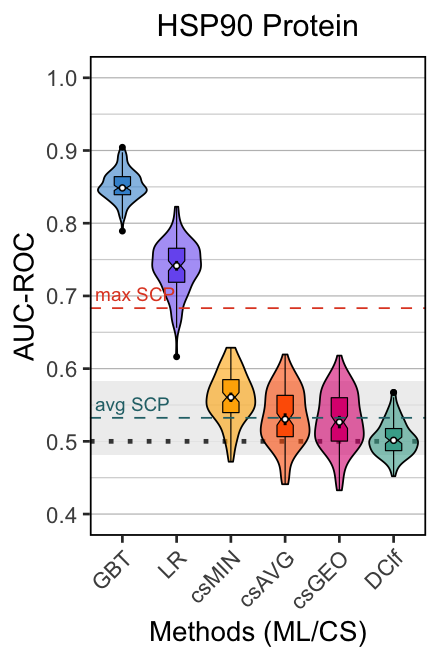

In [27]:
%%R  -i df_R -i scp_values_R -i protein_name -i ANALYSIS_TYPE -w 2.2 -h 3.3 --units in -r 200

source('../../R_scripts/plot_violinBox.R')

metric <- 'AUC-ROC'
p = plot_violin(df = df_R, 
                cbbPalette = cbbPalette,
                decreasing_order = TRUE, 
                y_min=0.4, y_max=1,
                dot_size = 4, scale='width', 
                violin_width=0.9,
                scp_values_R = scp_values_R
               ) +
ggtitle(paste(toupper(protein_name), 'Protein'))
p

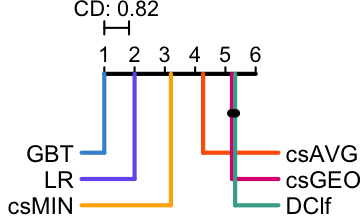

In [28]:
%%R -i df_R -i full_names -i protein_name -w 1.8 -h 1.1 --units in -r 200

source('../../R_scripts/plot_Critical_Difference.R')
df_R = df_R %>%
    mutate_all(round, 3)
metric <- 'AUC-ROC'
plot_Critical_Difference_color(df_R, 
             alpha = 0.01, cex = .65, 
             labels.cex = 0.7, 
             colPalette = cbbPalette, 
             side_marging = 10)

R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths


R[write to console]: PMCMR is superseded by PMCMRplus and will be no longer maintained. You may wish to install PMCMRplus instead.



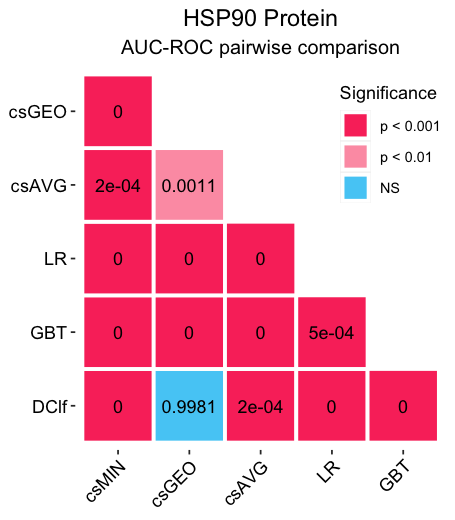

In [29]:
%%R -i df_R -i protein_name -w 3.5 -h 4 --units in -r 130

source('../../R_scripts/plot_p_vals_heatmap.R')
df_R = df_R %>%
    mutate_all(round, 3)
metric <- 'AUC-ROC'
p = plot_p_vals_heatmap(df_R) +
labs(title = paste(toupper(protein_name), 'Protein'),
     subtitle = paste(metric, "pairwise comparison"))

p

### NEF Results

In [30]:
# **********************
# Descriptive Statistics
# **********************

# NEF
metric_name='nef_Ra'
df_R = order_df(cv30x4, 
                metric_name).loc[metric_name]

scp_values_R = list(scp_values[metric_name])
# Descriptive statistics
report_descriptive_stats(cv30x4, metric_name)

Meadians:


,DClf,csGEO,csAVG,csMIN,LR,GBT
medians,0.09375,0.17188,0.17188,0.20312,0.375,0.51562


IQRs:


,DClf,csGEO,csAVG,csMIN,LR,GBT
IQRs,0.0625,0.0625,0.04687,0.04687,0.0625,0.05469


Normality test results (Sahpiro-Wilk):


,LR,GBT,DClf,csAVG,csGEO,csMIN
Normality,0,0,1,0,1,1


Friedman Test:


,chi^2,dof,p_value
Friedman Test,527.725,5,8.257890e-112


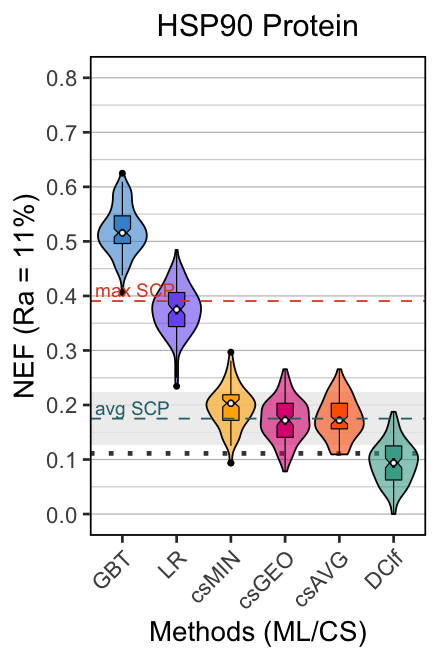

In [31]:
%%R  -i df_R -i scp_values_R -i R_a -i protein_name -w 2.2 -h 3.3 --units in -r 200

source('../../R_scripts/plot_violinBox.R')

metric <- 'NEF'
p = plot_violin(df = df_R, 
                cbbPalette = cbbPalette,
                y_min = 0.0, y_max = 0.8,
                base_h_line = R_a,
                y_label = paste0(metric, ' (Ra = ', round(R_a,2) *100 ,'%)'),
                scp_values_R = scp_values_R
               ) +
ggtitle(paste(toupper(protein_name), 'Protein'))

p

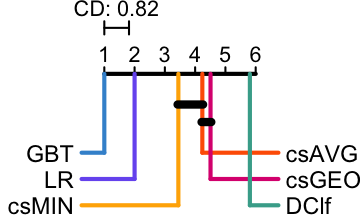

In [32]:
%%R -i df_R -i full_names -i protein_name -w 1.8 -h 1.1 --units in -r 200

source('../../R_scripts/plot_Critical_Difference.R')
df_R = df_R %>%
    mutate_all(round, 3)
metric <- 'NEF'
plot_Critical_Difference_color(df_R, 
             alpha = 0.01, cex = .65, 
             labels.cex = 0.7, 
             colPalette = cbbPalette, 
             side_marging = 10)


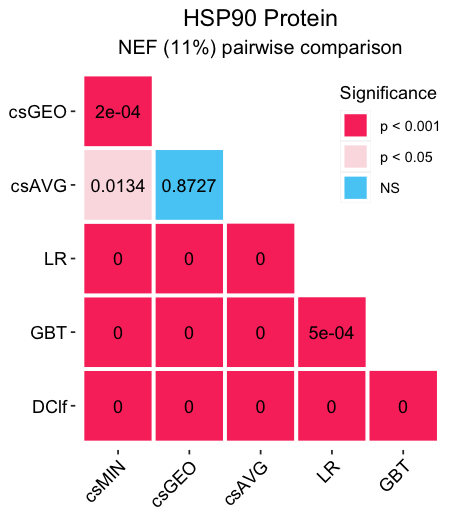

In [33]:
%%R -i df_R -i protein_name -i R_a -w 3.5 -h 4 --units in -r 130

source('../../R_scripts/plot_p_vals_heatmap.R')
df_R = df_R %>%
    mutate_all(round, 3)
metric <- 'NEF'
p = plot_p_vals_heatmap(df_R) +
labs(title = paste(toupper(protein_name), 'Protein'), 
     subtitle = paste0(metric, " (", round(R_a, 2) * 100,"%) pairwise comparison"))

p

Finished!